In [7]:
import sys
sys.path.append('..')

from IPython.display import clear_output, display

from utils.config_reader import ConfigReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

def load_config(config_file):
    return ConfigReader(config_file).cfg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
config_file = '../configs/cgem_evaluate_config.yaml'

config = load_config(config_file)

In [131]:
from utils.old_visualizer import Visualizer, draw_single
from utils.config_reader import ConfigReader
from utils.utils import get_events_df, parse_df, calc_purity_reduce_factor, apply_edge_restriction, apply_node_restriction
from utils.graph import to_nx_graph, to_line_graph, get_weight_stats, \
    get_linegraph_superedges_stat, to_pandas_graph_df, get_linegraph_stats_from_pandas, \
    get_reduced_df_graph, get_pd_line_graph, run_mbt_graph, calc_dphi


In [10]:
df = parse_df(config['df'])

In [11]:
df.x.min(), df.x.max(), df.y.min(), df.y.max(), df.z.min(), df.z.max()
df

,event,x,y,z,station,track
0,0,80.14192,15.11591,191.199900,0,-1
1,0,-63.89627,50.68022,-227.884400,0,-1
2,0,-63.89627,50.68022,197.887000,0,-1
3,0,-66.23155,47.58781,-232.431900,0,-1
4,0,-66.23155,47.58781,-31.974340,0,-1
...,...,...,...,...,...,...
10241246,199999,113.19590,-55.46663,-9.057016,1,15
10241247,199999,148.49450,-75.43168,-11.174930,2,15
10241248,199999,-80.06099,15.53888,57.396880,0,17
10241249,199999,-124.25600,21.22056,90.268650,1,17


In [12]:
events = get_events_df(config['df']['take'], df, preserve_fakes=True)

In [13]:
events

,event,station,track,z,r,phi
0,0,0,-1,0.725738,0.489526,0.186424
1,0,0,-1,0.230951,0.489526,2.471034
2,0,0,-1,0.733633,0.489526,2.471034
3,0,0,-1,0.225582,0.489526,2.518554
4,0,0,-1,0.462250,0.489526,2.518554
...,...,...,...,...,...,...
10241246,199999,1,15,0.489307,0.756633,-0.455620
10241247,199999,2,15,0.486806,0.999730,-0.470008
10241248,199999,0,17,0.567765,0.489526,2.949888
10241249,199999,1,17,0.606575,0.756633,2.972444


In [194]:
def get_edges_from_supernodes(sn_from, sn_to):
    prev_edges = sn_from.rename(columns={'to_ind':'cur_ind'})
    next_edges = sn_to.rename(columns={'from_ind':'cur_ind'})
    prev_edges['edge_index'] = prev_edges.index
    next_edges['edge_index'] = next_edges.index
    line_graph_edges = pd.merge(prev_edges, next_edges, on='cur_ind', suffixes=('_p', '_c'))

    line_graph_edges = line_graph_edges.assign(true_superedge=-1)
    index_true_superedge = line_graph_edges[(line_graph_edges.track_p == line_graph_edges.track_c) &
                                            (line_graph_edges.track_p != -1)]
    line_graph_edges.loc[index_true_superedge.index, 'true_superedge'] = index_true_superedge.track_p.values



    ba = line_graph_edges[['dx_p', 'dy_p', 'dz_p']].values
    cb = line_graph_edges[['dx_c', 'dy_c', 'dz_c']].values
    # norm_ba = np.linalg.norm(ba, axis=1)
    # norm_cb = np.linalg.norm(cb, axis=1)
    # dot = np.einsum('ij,ij->i', ba, cb)
    w = np.linalg.norm(ba - cb, axis=1)
    line_graph_edges['weight'] = w
    indexation = ['weight', 'true_superedge', 'edge_index_p', 'edge_index_c']
    return line_graph_edges[indexation]

In [202]:
def get_supernodes_df(linegraph_cfg, one_station_segments, station=-1, STAION_COUNT=0, pi_fix=False):
    ret = pd.DataFrame()
    axes = linegraph_cfg['axes']
    suffix_p, suffix_c = linegraph_cfg['suffix']
    
    x0_y0_z0 = one_station_segments[[axes[0] + suffix_p, axes[1] + suffix_p, axes[2] + suffix_p]].values
    x1_y1_z1 = one_station_segments[[axes[0] + suffix_c, axes[1] + suffix_c, axes[2] + suffix_c]].values
    dx_dy_dz = x1_y1_z1 - x0_y0_z0
    
    if pi_fix:
        dy_fixed = calc_dphi(one_station_segments[axes[1] + suffix_p].values, one_station_segments[axes[1] + suffix_c].values)
        ret = ret.assign(dx=dx_dy_dz[:, 0], dy=dy_fixed,
                         
                         z_p=one_station_segments[axes[2] + suffix_p].values,
                         z_c=one_station_segments[axes[2] + suffix_c].values,
                         y_p=one_station_segments[axes[1] + suffix_p].values,
                         y_c=one_station_segments[axes[1] + suffix_c].values,
                         
                         dz=dx_dy_dz[:, 2], z=(station+1)/STAION_COUNT)
    else:
        ret = ret.assign(dx=dx_dy_dz[:, 0], dy=dx_dy_dz[:, 1],
                         
                         z_p=one_station_segments[axes[2] + suffix_p].values,
                         z_c=one_station_segments[axes[2] + suffix_c].values,
                         y_p=one_station_segments[axes[1] + suffix_p].values,
                         y_c=one_station_segments[axes[1] + suffix_c].values,
                         
                         dz=dx_dy_dz[:, 2], z=(station+1)/STAION_COUNT)

    ret = ret.assign(from_ind=one_station_segments[['index_old'+suffix_p]].values.astype(np.uint32))
    ret = ret.assign(to_ind=one_station_segments[['index_old'+suffix_c]].values.astype(np.uint32))
    ret = ret.assign(track=-1)
    ret = ret.set_index(one_station_segments.index)
    index_true_superedge = one_station_segments[(one_station_segments['track'+suffix_p] == one_station_segments['track'+suffix_c]) &\
                                            (one_station_segments['track'+suffix_p] != -1)]
    ret.loc[index_true_superedge.index, 'track'] = index_true_superedge['track'+suffix_p].values
    ret = ret.assign(station=station)
    return ret

In [229]:
def get_pd_line_graph(prepare_cfg, segments, restrictions_func, pi_fix):
    nodes = pd.DataFrame()
    edges = pd.DataFrame()
    
    restrictions_0, restrictions_1  = config['prepare']['linegraph']['restrictions']
    
    by_stations = [df for (ind, df) in segments.groupby('station' + prepare_cfg['linegraph']['suffix'][0])]
    for i in range(1, len(by_stations)):        
        supernodes_from = get_supernodes_df(prepare_cfg['linegraph'], by_stations[i - 1], i-1, 3, pi_fix=True)
        supernodes_to = get_supernodes_df(prepare_cfg['linegraph'], by_stations[i], i, 3, pi_fix=True)
        
        if restrictions_func:
            supernodes_from = restrictions_func(supernodes_from, restrictions_0, restrictions_1)
            supernodes_to = restrictions_func(supernodes_to, restrictions_0, restrictions_1)

        nodes = nodes.append(supernodes_from, sort=False)
        nodes = nodes.append(supernodes_to, sort=False)
            
        superedges = get_edges_from_supernodes(supernodes_from, supernodes_to)
        edges = edges.append(superedges, ignore_index=True, sort=False)
        
    nodes = nodes.loc[~nodes.index.duplicated(keep='first')]
    return nodes, edges

In [230]:
def apply_nodes_restrictions(nodes, restrictions_0, restrictions_1):
    return nodes[
        (nodes.dy > restrictions_0[0]) & (nodes.dy < restrictions_0[1]) &
        (nodes.dz > restrictions_1[0]) & (nodes.dz < restrictions_1[1])
        ]

G = to_pandas_graph_df(events[events.event == 4], suffx=config['prepare']['linegraph']['suffix'])
nodes = get_pd_line_graph(config['prepare'], G, apply_nodes_restrictions, pi_fix=True)

In [198]:
nodes[0]

,dx,dy,z_p,z_c,y_p,y_c,dz,z,from_ind,to_ind,track,station
0,0.267107,0.046870,0.618440,0.103509,1.622987,1.669857,-0.514931,0.333333,132,138,-1,0
1,0.267107,0.046870,0.618440,0.704512,1.622987,1.669857,0.086072,0.333333,132,139,-1,0
2,0.267107,0.556152,0.618440,0.607130,1.622987,2.179139,-0.011310,0.333333,132,140,-1,0
3,0.267107,0.556152,0.618440,0.570227,1.622987,2.179139,-0.048213,0.333333,132,144,-1,0
4,0.267107,1.773247,0.618440,0.476666,1.622987,-2.886952,-0.141774,0.333333,132,147,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.243097,0.043421,0.741415,0.717635,1.669857,1.713278,-0.023780,0.666667,150,141,-1,1
80,0.243097,0.445483,0.741415,0.690506,1.669857,2.115340,-0.050909,0.666667,150,142,-1,1
81,0.243097,0.445483,0.741415,0.589506,1.669857,2.115340,-0.151910,0.666667,150,145,-1,1
82,0.243097,1.697662,0.741415,0.468850,1.669857,-2.915666,-0.272565,0.666667,150,148,-1,1


In [171]:
events[events.event == 4]

,event,station,track,z,r,phi
132,4,0,-1,0.618440,0.489526,1.622987
133,4,0,-1,0.690460,0.489526,1.622987
134,4,0,-1,0.587102,0.489526,2.251711
135,4,0,-1,0.619426,0.489526,2.251711
136,4,0,-1,0.414423,0.489526,-2.854443
137,4,0,-1,0.454119,0.489526,-2.854443
138,4,1,-1,0.103509,0.756633,1.669857
139,4,1,-1,0.704512,0.756633,1.669857
140,4,1,-1,0.607130,0.756633,2.179139
141,4,2,-1,0.717635,0.999730,1.713278


In [231]:
events_to_analyze = events[events.event < 100]
segments = pd.DataFrame()
suffx = config['prepare']['linegraph']['suffix']

nodes = pd.DataFrame()
edges = pd.DataFrame()

for id, event in events_to_analyze.groupby('event'):
    clear_output(wait=True)
    display("Event #%09d" % id)
    
    G = to_pandas_graph_df(event, suffx=suffx)
    nodes_t, edges_t = get_pd_line_graph(config['prepare'], G, apply_nodes_restrictions, pi_fix=True)
    nodes = nodes.append(nodes_t, sort=False)
    edges = edges.append(edges_t, sort=False)

'Event #000000099'

In [227]:
nodes

,dx,dy,z_p,z_c,y_p,y_c,dz,z,from_ind,to_ind,track,station
0,0.267107,-0.015031,0.725738,0.788574,0.186424,0.171393,0.062836,0.333333,0,16,-1,0
1,0.267107,2.291428,0.725738,0.180418,0.186424,2.477852,-0.545320,0.333333,0,17,-1,0
2,0.267107,2.291428,0.725738,0.522342,0.186424,2.477852,-0.203396,0.333333,0,18,-1,0
3,0.267107,2.291428,0.725738,0.623262,0.186424,2.477852,-0.102475,0.333333,0,19,-1,0
4,0.267107,2.291428,0.725738,0.797990,0.186424,2.477852,0.072252,0.333333,0,20,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.243097,-0.505464,0.358580,0.493208,-0.294021,-0.799485,0.134628,0.666667,50995,50986,-1,1
188,0.243097,0.070650,0.358580,0.318900,-0.294021,-0.223371,-0.039680,0.666667,50995,50987,-1,1
189,0.243097,0.331676,0.358580,0.757477,-0.294021,0.037654,0.398897,0.666667,50995,50990,-1,1
190,0.243097,-0.505464,0.358580,0.502497,-0.294021,-0.799485,0.143916,0.666667,50995,50993,-1,1


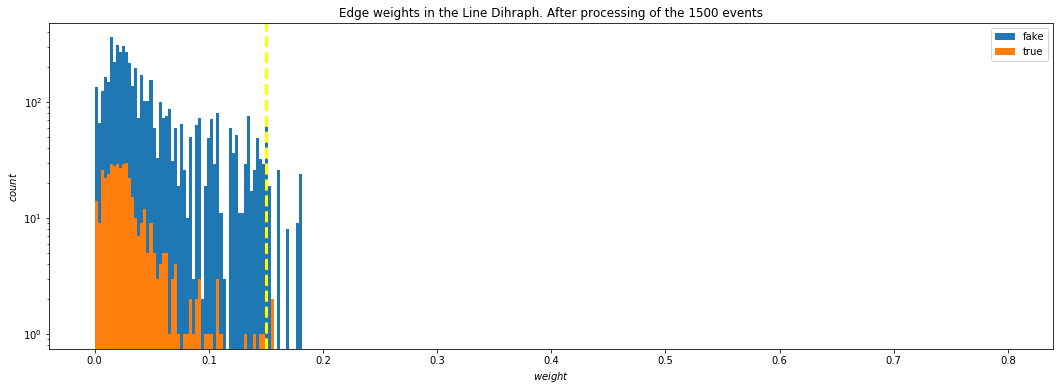

In [233]:
true_nodes = nodes[nodes.track != -1]
fake_nodes = nodes[nodes.track == -1]

plt.figure(figsize=(18,6))

plt.subplot(111)
binning=dict(bins=300, range=(0, 0.8))
plt.hist(fake_nodes.dy, label='fake', log=True, **binning)
plt.hist(true_nodes.dy, label='true', **binning)
#plt.axvline(-0.15, color='yellow', linestyle='dashed', linewidth=3)
plt.axvline(0.15, color='yellow', linestyle='dashed', linewidth=3)
plt.title('Edge weights in the Line Dihraph. After processing of the 1500 events')
plt.ylabel('$count$')
plt.xlabel('$weight$')
plt.legend(loc=0)



In [206]:
true_segs = edges[edges.true_superedge != -1]
fake_segs = edges[edges.true_superedge == -1]

In [207]:
fake_segs['weight'].describe()

count    177520.000000
mean          0.137761
std           0.077099
min           0.024010
25%           0.074562
50%           0.128562
75%           0.190884
max           0.433471
Name: weight, dtype: float64

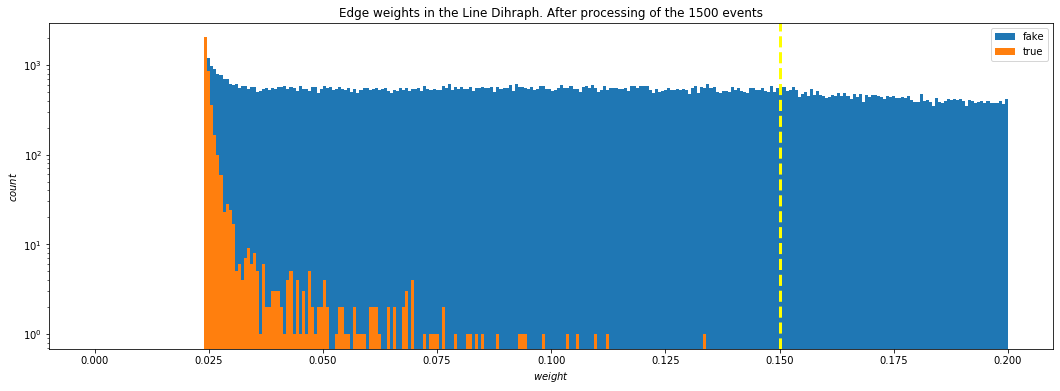

In [208]:
plt.figure(figsize=(18,6))

plt.subplot(111)
binning=dict(bins=300, range=(0, 0.2))
plt.hist(fake_segs.weight, label='fake', log=True, **binning)
plt.hist(true_segs.weight, label='true', **binning)
#plt.axvline(-0.15, color='yellow', linestyle='dashed', linewidth=3)
plt.axvline(0.15, color='yellow', linestyle='dashed', linewidth=3)
plt.title('Edge weights in the Line Dihraph. After processing of the 1500 events')
plt.ylabel('$count$')
plt.xlabel('$weight$')
plt.legend(loc=0)

# plt.subplot(122)
# binning=dict(bins=300, range=(-0.15, 0.15))
# plt.hist(fake_segs.weight, label='fake', log=True, **binning)
# plt.hist(true_segs.weight, label='true', **binning)
# plt.axvline(-0.15, color='yellow', linestyle='dashed', linewidth=3)
# plt.axvline(0.15, color='yellow', linestyle='dashed', linewidth=3)
# plt.xlabel('$weight$')
# plt.legend(loc=0)


In [ ]:
def filter_segments(df, dphi_min, dphi_max, dz_min, dz_max):
    return df[
        (df.dphi > dphi_min) & (df.dphi < dphi_max) &
        (df.dz > dz_min) & (df.dz < dz_max)
    ]


dphi_minmax = (-0.18, 0.18)
dz_minmax = (-0.15, 0.15)

filtered = filter_segments(segments, *dphi_minmax, *dz_minmax)

purity_, reduce_ = calc_purity_reduce_factor(segments, filtered, 'track', False)
print("Initial fake to real ratio is %.6f" % (len(segments) / len(segments[segments.track])))
print("Currently fake to real ratio is %.6f" % (len(filtered) / len(filtered[filtered.track])))
print("Result purity %.3f; segments filtering reduced ratio in %.3f times" % (purity_, reduce_))

In [219]:
def apply_edge_restriction(pd_edges_df, RESTRICTION=0.15):
    assert 'weight' in pd_edges_df
    return pd_edges_df[pd_edges_df.weight < RESTRICTION]


filtered = apply_edge_restriction(edges, 0.073)

purity_, reduce_ = calc_purity_reduce_factor(edges, filtered, 'true_superedge', -1)
print("Initial fake to real ratio is %.6f" % (len(edges) / len(edges[edges.true_superedge != -1])))
print("Currently fake to real ratio is %.6f" % (len(filtered) / len(filtered[filtered.true_superedge != -1])))
print("Result purity %.3f; segments filtering reduced ratio in %.3f times" % (purity_, reduce_))

Initial fake to real ratio is 47.568730
Currently fake to real ratio is 12.369726
Result purity 0.995; segments filtering reduced ratio in 3.866 times
